In [1]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [50]:
# Root directory for dataset
dataroot = "../Asset/flowers"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 8000

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

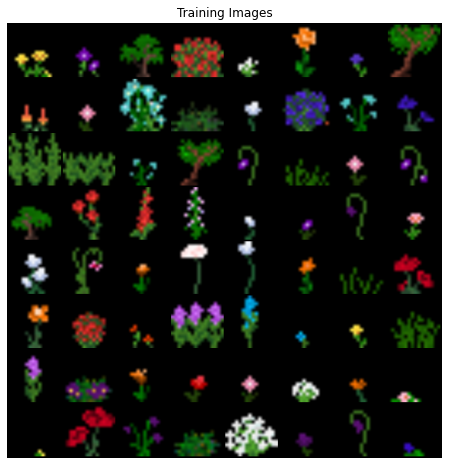

In [51]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

In [52]:
#custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [53]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        return self.main(input)

In [54]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netG.apply(weights_init)

# Print the model
print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [55]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [56]:
# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the weights_init function to randomly initialize all weights
#  to mean=0, stdev=0.2.
netD.apply(weights_init)

# Print the model
print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [57]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/8000][0/1]	Loss_D: 1.3661	Loss_G: 3.8595	D(x): 0.5020	D(G(z)): 0.3609 / 0.0280
[1/8000][0/1]	Loss_D: 1.6531	Loss_G: 5.3998	D(x): 0.9986	D(G(z)): 0.7383 / 0.0096
[2/8000][0/1]	Loss_D: 0.4221	Loss_G: 6.8104	D(x): 0.9977	D(G(z)): 0.2988 / 0.0018
[3/8000][0/1]	Loss_D: 0.1977	Loss_G: 6.6615	D(x): 0.9916	D(G(z)): 0.1567 / 0.0022
[4/8000][0/1]	Loss_D: 0.1886	Loss_G: 6.5248	D(x): 0.9862	D(G(z)): 0.1476 / 0.0023
[5/8000][0/1]	Loss_D: 0.3801	Loss_G: 7.7108	D(x): 0.9871	D(G(z)): 0.2688 / 0.0008
[6/8000][0/1]	Loss_D: 0.0986	Loss_G: 7.5879	D(x): 0.9742	D(G(z)): 0.0658 / 0.0009
[7/8000][0/1]	Loss_D: 0.1080	Loss_G: 7.0585	D(x): 0.9790	D(G(z)): 0.0791 / 0.0014
[8/8000][0/1]	Loss_D: 0.2247	Loss_G: 8.6546	D(x): 0.9805	D(G(z)): 0.1722 / 0.0003
[9/8000][0/1]	Loss_D: 0.0898	Loss_G: 8.1955	D(x): 0.9686	D(G(z)): 0.0532 / 0.0005
[10/8000][0/1]	Loss_D: 0.1368	Loss_G: 8.5550	D(x): 0.9764	D(G(z)): 0.1000 / 0.0003
[11/8000][0/1]	Loss_D: 0.1055	Loss_G: 8.8585	D(x): 0.9749	D(G(z)): 0.07

[98/8000][0/1]	Loss_D: 0.0669	Loss_G: 7.6965	D(x): 0.9712	D(G(z)): 0.0359 / 0.0007
[99/8000][0/1]	Loss_D: 0.0495	Loss_G: 7.1906	D(x): 0.9695	D(G(z)): 0.0179 / 0.0011
[100/8000][0/1]	Loss_D: 0.0646	Loss_G: 7.8247	D(x): 0.9754	D(G(z)): 0.0378 / 0.0006
[101/8000][0/1]	Loss_D: 0.0446	Loss_G: 7.4332	D(x): 0.9707	D(G(z)): 0.0143 / 0.0010
[102/8000][0/1]	Loss_D: 0.0529	Loss_G: 7.2746	D(x): 0.9768	D(G(z)): 0.0283 / 0.0010
[103/8000][0/1]	Loss_D: 0.0509	Loss_G: 7.5615	D(x): 0.9770	D(G(z)): 0.0267 / 0.0007
[104/8000][0/1]	Loss_D: 0.0427	Loss_G: 7.1800	D(x): 0.9754	D(G(z)): 0.0172 / 0.0011
[105/8000][0/1]	Loss_D: 0.0561	Loss_G: 7.6267	D(x): 0.9783	D(G(z)): 0.0329 / 0.0006
[106/8000][0/1]	Loss_D: 0.0452	Loss_G: 7.5260	D(x): 0.9748	D(G(z)): 0.0189 / 0.0007
[107/8000][0/1]	Loss_D: 0.0469	Loss_G: 7.3463	D(x): 0.9765	D(G(z)): 0.0225 / 0.0009
[108/8000][0/1]	Loss_D: 0.0463	Loss_G: 7.5119	D(x): 0.9782	D(G(z)): 0.0236 / 0.0008
[109/8000][0/1]	Loss_D: 0.0459	Loss_G: 7.6709	D(x): 0.9786	D(G(z)): 0.0235 / 0

[196/8000][0/1]	Loss_D: 0.0096	Loss_G: 8.0224	D(x): 0.9973	D(G(z)): 0.0069 / 0.0004
[197/8000][0/1]	Loss_D: 0.0096	Loss_G: 7.5286	D(x): 0.9973	D(G(z)): 0.0068 / 0.0006
[198/8000][0/1]	Loss_D: 0.0092	Loss_G: 7.2284	D(x): 0.9974	D(G(z)): 0.0065 / 0.0008
[199/8000][0/1]	Loss_D: 0.0081	Loss_G: 7.1327	D(x): 0.9975	D(G(z)): 0.0056 / 0.0009
[200/8000][0/1]	Loss_D: 0.0115	Loss_G: 7.0313	D(x): 0.9977	D(G(z)): 0.0091 / 0.0010
[201/8000][0/1]	Loss_D: 0.0131	Loss_G: 7.2674	D(x): 0.9977	D(G(z)): 0.0108 / 0.0008
[202/8000][0/1]	Loss_D: 0.0155	Loss_G: 7.5817	D(x): 0.9977	D(G(z)): 0.0131 / 0.0006
[203/8000][0/1]	Loss_D: 0.0084	Loss_G: 7.5911	D(x): 0.9976	D(G(z)): 0.0060 / 0.0006
[204/8000][0/1]	Loss_D: 0.0104	Loss_G: 7.3176	D(x): 0.9976	D(G(z)): 0.0080 / 0.0007
[205/8000][0/1]	Loss_D: 0.0101	Loss_G: 7.2186	D(x): 0.9976	D(G(z)): 0.0077 / 0.0008
[206/8000][0/1]	Loss_D: 0.0079	Loss_G: 7.2267	D(x): 0.9977	D(G(z)): 0.0055 / 0.0008
[207/8000][0/1]	Loss_D: 0.0079	Loss_G: 7.0450	D(x): 0.9978	D(G(z)): 0.0056 /

[294/8000][0/1]	Loss_D: 0.0036	Loss_G: 7.1155	D(x): 0.9989	D(G(z)): 0.0024 / 0.0009
[295/8000][0/1]	Loss_D: 0.0048	Loss_G: 6.8396	D(x): 0.9989	D(G(z)): 0.0037 / 0.0012
[296/8000][0/1]	Loss_D: 0.0050	Loss_G: 6.8817	D(x): 0.9989	D(G(z)): 0.0039 / 0.0011
[297/8000][0/1]	Loss_D: 0.0057	Loss_G: 6.9404	D(x): 0.9989	D(G(z)): 0.0046 / 0.0010
[298/8000][0/1]	Loss_D: 0.0043	Loss_G: 7.1445	D(x): 0.9989	D(G(z)): 0.0032 / 0.0009
[299/8000][0/1]	Loss_D: 0.0055	Loss_G: 6.9505	D(x): 0.9989	D(G(z)): 0.0044 / 0.0010
[300/8000][0/1]	Loss_D: 0.0053	Loss_G: 7.0627	D(x): 0.9989	D(G(z)): 0.0042 / 0.0009
[301/8000][0/1]	Loss_D: 0.0038	Loss_G: 7.2051	D(x): 0.9989	D(G(z)): 0.0027 / 0.0008
[302/8000][0/1]	Loss_D: 0.0039	Loss_G: 7.0936	D(x): 0.9989	D(G(z)): 0.0028 / 0.0009
[303/8000][0/1]	Loss_D: 0.0037	Loss_G: 7.0124	D(x): 0.9989	D(G(z)): 0.0026 / 0.0009
[304/8000][0/1]	Loss_D: 0.0048	Loss_G: 6.8751	D(x): 0.9990	D(G(z)): 0.0037 / 0.0011
[305/8000][0/1]	Loss_D: 0.0065	Loss_G: 6.9496	D(x): 0.9990	D(G(z)): 0.0054 /

[392/8000][0/1]	Loss_D: 0.0015	Loss_G: 7.6820	D(x): 0.9993	D(G(z)): 0.0008 / 0.0005
[393/8000][0/1]	Loss_D: 0.0022	Loss_G: 7.1547	D(x): 0.9993	D(G(z)): 0.0016 / 0.0009
[394/8000][0/1]	Loss_D: 0.0022	Loss_G: 7.1562	D(x): 0.9994	D(G(z)): 0.0016 / 0.0008
[395/8000][0/1]	Loss_D: 0.0036	Loss_G: 6.9076	D(x): 0.9994	D(G(z)): 0.0029 / 0.0011
[396/8000][0/1]	Loss_D: 0.0032	Loss_G: 7.0734	D(x): 0.9994	D(G(z)): 0.0026 / 0.0009
[397/8000][0/1]	Loss_D: 0.0033	Loss_G: 7.1948	D(x): 0.9994	D(G(z)): 0.0027 / 0.0009
[398/8000][0/1]	Loss_D: 0.0026	Loss_G: 7.3042	D(x): 0.9993	D(G(z)): 0.0019 / 0.0007
[399/8000][0/1]	Loss_D: 0.0022	Loss_G: 7.4188	D(x): 0.9993	D(G(z)): 0.0015 / 0.0007
[400/8000][0/1]	Loss_D: 0.0020	Loss_G: 7.3677	D(x): 0.9993	D(G(z)): 0.0014 / 0.0007
[401/8000][0/1]	Loss_D: 0.0018	Loss_G: 7.4745	D(x): 0.9993	D(G(z)): 0.0012 / 0.0006
[402/8000][0/1]	Loss_D: 0.0022	Loss_G: 7.2179	D(x): 0.9994	D(G(z)): 0.0015 / 0.0008
[403/8000][0/1]	Loss_D: 0.0025	Loss_G: 7.1350	D(x): 0.9994	D(G(z)): 0.0019 /

[490/8000][0/1]	Loss_D: 0.0015	Loss_G: 7.5115	D(x): 0.9995	D(G(z)): 0.0010 / 0.0006
[491/8000][0/1]	Loss_D: 0.0018	Loss_G: 7.3554	D(x): 0.9995	D(G(z)): 0.0013 / 0.0007
[492/8000][0/1]	Loss_D: 0.0020	Loss_G: 7.2856	D(x): 0.9995	D(G(z)): 0.0016 / 0.0008
[493/8000][0/1]	Loss_D: 0.0030	Loss_G: 7.0472	D(x): 0.9995	D(G(z)): 0.0025 / 0.0010
[494/8000][0/1]	Loss_D: 0.0030	Loss_G: 7.1805	D(x): 0.9995	D(G(z)): 0.0025 / 0.0008
[495/8000][0/1]	Loss_D: 0.0018	Loss_G: 7.5823	D(x): 0.9995	D(G(z)): 0.0013 / 0.0006
[496/8000][0/1]	Loss_D: 0.0012	Loss_G: 8.0017	D(x): 0.9995	D(G(z)): 0.0007 / 0.0004
[497/8000][0/1]	Loss_D: 0.0010	Loss_G: 8.1254	D(x): 0.9995	D(G(z)): 0.0005 / 0.0003
[498/8000][0/1]	Loss_D: 0.0014	Loss_G: 7.5036	D(x): 0.9995	D(G(z)): 0.0009 / 0.0006
[499/8000][0/1]	Loss_D: 0.0021	Loss_G: 7.1462	D(x): 0.9995	D(G(z)): 0.0016 / 0.0009
[500/8000][0/1]	Loss_D: 0.0016	Loss_G: 7.4405	D(x): 0.9995	D(G(z)): 0.0011 / 0.0006
[501/8000][0/1]	Loss_D: 0.0015	Loss_G: 7.5536	D(x): 0.9995	D(G(z)): 0.0010 /

[588/8000][0/1]	Loss_D: 0.0009	Loss_G: 8.1744	D(x): 0.9996	D(G(z)): 0.0005 / 0.0003
[589/8000][0/1]	Loss_D: 0.0010	Loss_G: 7.9068	D(x): 0.9996	D(G(z)): 0.0006 / 0.0004
[590/8000][0/1]	Loss_D: 0.0014	Loss_G: 7.5135	D(x): 0.9996	D(G(z)): 0.0010 / 0.0006
[591/8000][0/1]	Loss_D: 0.0019	Loss_G: 7.3177	D(x): 0.9996	D(G(z)): 0.0015 / 0.0007
[592/8000][0/1]	Loss_D: 0.0013	Loss_G: 7.7063	D(x): 0.9996	D(G(z)): 0.0009 / 0.0005
[593/8000][0/1]	Loss_D: 0.0012	Loss_G: 7.7632	D(x): 0.9996	D(G(z)): 0.0008 / 0.0005
[594/8000][0/1]	Loss_D: 0.0008	Loss_G: 8.1762	D(x): 0.9996	D(G(z)): 0.0004 / 0.0003
[595/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.7201	D(x): 0.9996	D(G(z)): 0.0002 / 0.0002
[596/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.2345	D(x): 0.9996	D(G(z)): 0.0004 / 0.0003
[597/8000][0/1]	Loss_D: 0.0011	Loss_G: 7.5588	D(x): 0.9996	D(G(z)): 0.0008 / 0.0006
[598/8000][0/1]	Loss_D: 0.0023	Loss_G: 7.1048	D(x): 0.9997	D(G(z)): 0.0019 / 0.0009
[599/8000][0/1]	Loss_D: 0.0015	Loss_G: 7.5500	D(x): 0.9996	D(G(z)): 0.0012 /

[686/8000][0/1]	Loss_D: 0.0012	Loss_G: 7.5243	D(x): 0.9997	D(G(z)): 0.0009 / 0.0006
[687/8000][0/1]	Loss_D: 0.0013	Loss_G: 7.5275	D(x): 0.9997	D(G(z)): 0.0010 / 0.0006
[688/8000][0/1]	Loss_D: 0.0011	Loss_G: 7.7669	D(x): 0.9997	D(G(z)): 0.0008 / 0.0005
[689/8000][0/1]	Loss_D: 0.0011	Loss_G: 7.7218	D(x): 0.9997	D(G(z)): 0.0008 / 0.0005
[690/8000][0/1]	Loss_D: 0.0013	Loss_G: 7.5876	D(x): 0.9997	D(G(z)): 0.0010 / 0.0006
[691/8000][0/1]	Loss_D: 0.0009	Loss_G: 7.9835	D(x): 0.9997	D(G(z)): 0.0006 / 0.0004
[692/8000][0/1]	Loss_D: 0.0009	Loss_G: 7.9050	D(x): 0.9997	D(G(z)): 0.0006 / 0.0004
[693/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.3027	D(x): 0.9997	D(G(z)): 0.0004 / 0.0003
[694/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.2732	D(x): 0.9997	D(G(z)): 0.0004 / 0.0003
[695/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.3028	D(x): 0.9997	D(G(z)): 0.0003 / 0.0003
[696/8000][0/1]	Loss_D: 0.0010	Loss_G: 7.6720	D(x): 0.9997	D(G(z)): 0.0007 / 0.0005
[697/8000][0/1]	Loss_D: 0.0015	Loss_G: 7.3636	D(x): 0.9997	D(G(z)): 0.0012 /

[784/8000][0/1]	Loss_D: 0.0008	Loss_G: 8.0312	D(x): 0.9998	D(G(z)): 0.0005 / 0.0004
[785/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.2385	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[786/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.0975	D(x): 0.9998	D(G(z)): 0.0005 / 0.0003
[787/8000][0/1]	Loss_D: 0.0010	Loss_G: 7.7040	D(x): 0.9998	D(G(z)): 0.0008 / 0.0005
[788/8000][0/1]	Loss_D: 0.0010	Loss_G: 7.7849	D(x): 0.9998	D(G(z)): 0.0008 / 0.0005
[789/8000][0/1]	Loss_D: 0.0008	Loss_G: 8.1189	D(x): 0.9998	D(G(z)): 0.0005 / 0.0003
[790/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.2513	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[791/8000][0/1]	Loss_D: 0.0009	Loss_G: 7.7929	D(x): 0.9998	D(G(z)): 0.0007 / 0.0004
[792/8000][0/1]	Loss_D: 0.0009	Loss_G: 7.9254	D(x): 0.9998	D(G(z)): 0.0006 / 0.0004
[793/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.4504	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[794/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.3088	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[795/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.0067	D(x): 0.9998	D(G(z)): 0.0005 /

[882/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.5498	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[883/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.3627	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[884/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6082	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[885/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.1656	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[886/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.2357	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[887/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.4503	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[888/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.7533	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[889/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6500	D(x): 0.9998	D(G(z)): 0.0002 / 0.0002
[890/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.2935	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[891/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.2306	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[892/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5420	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[893/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6940	D(x): 0.9998	D(G(z)): 0.0002 /

[980/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5528	D(x): 0.9998	D(G(z)): 0.0003 / 0.0002
[981/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.1531	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[982/8000][0/1]	Loss_D: 0.0007	Loss_G: 7.9965	D(x): 0.9998	D(G(z)): 0.0006 / 0.0004
[983/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.1867	D(x): 0.9998	D(G(z)): 0.0004 / 0.0003
[984/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.9893	D(x): 0.9998	D(G(z)): 0.0002 / 0.0001
[985/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5618	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[986/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5493	D(x): 0.9998	D(G(z)): 0.0001 / 0.0001
[987/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.3104	D(x): 0.9998	D(G(z)): 0.0003 / 0.0003
[988/8000][0/1]	Loss_D: 0.0008	Loss_G: 7.7806	D(x): 0.9998	D(G(z)): 0.0006 / 0.0004
[989/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.0342	D(x): 0.9998	D(G(z)): 0.0005 / 0.0004
[990/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.0646	D(x): 0.9998	D(G(z)): 0.0005 / 0.0003
[991/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.4164	D(x): 0.9998	D(G(z)): 0.0003 /

[1077/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.2230	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[1078/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.2800	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[1079/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5382	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1080/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6562	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1081/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5833	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1082/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5002	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1083/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6579	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1084/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5148	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1085/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.4858	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1086/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6240	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1087/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.3870	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1088/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.3264	D(x): 0.9999	D(G(z

[1174/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5720	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1175/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.6096	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1176/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5967	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1177/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.4702	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1178/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.0870	D(x): 0.9999	D(G(z)): 0.0005 / 0.0003
[1179/8000][0/1]	Loss_D: 0.0005	Loss_G: 8.2170	D(x): 0.9999	D(G(z)): 0.0004 / 0.0003
[1180/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.8468	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1181/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.4100	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1182/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5384	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1183/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.8015	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1184/8000][0/1]	Loss_D: 0.0003	Loss_G: 9.0310	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1185/8000][0/1]	Loss_D: 0.0003	Loss_G: 9.1208	D(x): 0.9999	D(G(z

[1271/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.9803	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1272/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.7496	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1273/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5511	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1274/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.8625	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1275/8000][0/1]	Loss_D: 0.0003	Loss_G: 9.0083	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1276/8000][0/1]	Loss_D: 0.0003	Loss_G: 9.0160	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1277/8000][0/1]	Loss_D: 0.0003	Loss_G: 9.0180	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1278/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.9939	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1279/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.9629	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1280/8000][0/1]	Loss_D: 0.0004	Loss_G: 8.5074	D(x): 0.9999	D(G(z)): 0.0003 / 0.0002
[1281/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.7451	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1282/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.6575	D(x): 0.9999	D(G(z

[1368/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.1572	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1369/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0053	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1370/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0829	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1371/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0268	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1372/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.7905	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1373/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.6348	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1374/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.9708	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1375/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5001	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1376/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.1135	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1377/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0060	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1378/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.8937	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1379/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.4885	D(x): 0.9999	D(G(z

[1465/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0057	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1466/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2571	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1467/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.4750	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1468/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0557	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1469/8000][0/1]	Loss_D: 0.0003	Loss_G: 8.7633	D(x): 0.9999	D(G(z)): 0.0002 / 0.0002
[1470/8000][0/1]	Loss_D: 0.0002	Loss_G: 8.9290	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1471/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3455	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1472/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.6037	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1473/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6946	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1474/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7078	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1475/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5503	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1476/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0619	D(x): 0.9999	D(G(z

[1562/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.1616	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1563/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2663	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1564/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2198	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1565/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6121	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1566/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0507	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[1567/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0292	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[1568/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3686	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1569/8000][0/1]	Loss_D: 0.0002	Loss_G: 8.9677	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1570/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.1106	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1571/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2852	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1572/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2314	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1573/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2734	D(x): 0.9999	D(G

[1659/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2582	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1660/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2439	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1661/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7270	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1662/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3361	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1663/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0918	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1664/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3286	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1665/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0413	D(x): 0.9999	D(G(z)): 0.0001 / 0.0000
[1666/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5234	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1667/8000][0/1]	Loss_D: 0.0002	Loss_G: 8.9527	D(x): 0.9999	D(G(z)): 0.0002 / 0.0001
[1668/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.0911	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1669/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5893	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[1670/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.2769	D(x): 0.9999	D(G

[1756/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9623	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[1757/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8180	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1758/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7699	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1759/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4012	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1760/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7585	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1761/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.2158	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1762/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9099	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1763/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9460	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[1764/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.1308	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1765/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7418	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1766/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3298	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1767/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2504	D(x): 1.0000	D(G

[1853/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5636	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1854/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4889	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1855/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5670	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1856/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8294	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1857/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7684	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1858/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7210	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1859/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8115	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1860/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7157	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1861/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5390	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1862/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4879	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1863/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5762	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1864/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6298	D(x): 1.0000	D(G(z

[1950/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.5393	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1951/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0605	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[1952/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6183	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1953/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5132	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1954/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5804	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1955/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0204	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[1956/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9503	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[1957/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5357	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1958/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2777	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1959/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4853	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1960/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7891	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[1961/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8719	D(x): 1.0000	D(

[2047/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0064	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[2048/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8964	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2049/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8568	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2050/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7126	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2051/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7184	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2052/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9957	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[2053/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.3375	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2054/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.3704	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2055/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7235	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2056/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4418	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2057/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5176	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2058/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7820	D(x): 1.0000	D(

[2143/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0727	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2144/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.5483	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2145/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.8084	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2146/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.2466	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2147/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6826	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2148/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.5561	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2149/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4996	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2150/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6431	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2151/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9072	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2152/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.4616	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2153/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.6052	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2154/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.3657	D(x): 1.000

[2239/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7305	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2240/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6739	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2241/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9474	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[2242/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.3082	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2243/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0634	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2244/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.2036	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2245/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.1411	D(x): 1.0000	D(G(z)): 0.0000 / 0.0000
[2246/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.6490	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2247/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.4294	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2248/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8122	D(x): 1.0000	D(G(z)): 0.0001 / 0.0001
[2249/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9467	D(x): 1.0000	D(G(z)): 0.0001 / 0.0000
[2250/8000][0/1]	Loss_D: 0.0001	Loss_G: 10.0866	D(x): 1.0000	

[2336/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8281	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2337/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.8420	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2338/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.3405	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2339/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.2743	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2340/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.4465	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2341/8000][0/1]	Loss_D: 0.0002	Loss_G: 9.5326	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2342/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7598	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2343/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7948	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2344/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7456	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2345/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.7179	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2346/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9378	D(x): 0.9999	D(G(z)): 0.0001 / 0.0001
[2347/8000][0/1]	Loss_D: 0.0001	Loss_G: 9.9030	D(x): 0.9999	D(G(z

[2433/8000][0/1]	Loss_D: 0.0005	Loss_G: 9.0299	D(x): 0.9998	D(G(z)): 0.0003 / 0.0001
[2434/8000][0/1]	Loss_D: 0.0005	Loss_G: 9.0167	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[2435/8000][0/1]	Loss_D: 0.0005	Loss_G: 9.0398	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[2436/8000][0/1]	Loss_D: 0.0005	Loss_G: 9.0146	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[2437/8000][0/1]	Loss_D: 0.0005	Loss_G: 9.0357	D(x): 0.9997	D(G(z)): 0.0002 / 0.0001
[2438/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.9973	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[2439/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.9519	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[2440/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.9608	D(x): 0.9997	D(G(z)): 0.0003 / 0.0001
[2441/8000][0/1]	Loss_D: 0.0007	Loss_G: 9.0229	D(x): 0.9996	D(G(z)): 0.0003 / 0.0001
[2442/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.9799	D(x): 0.9996	D(G(z)): 0.0003 / 0.0001
[2443/8000][0/1]	Loss_D: 0.0006	Loss_G: 8.9697	D(x): 0.9996	D(G(z)): 0.0003 / 0.0001
[2444/8000][0/1]	Loss_D: 0.0007	Loss_G: 8.9856	D(x): 0.9996	D(G(z

[2529/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1952	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2530/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1930	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2531/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1953	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2532/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1907	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2533/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1955	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2534/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1947	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2535/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1965	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2536/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1932	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2537/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1929	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2538/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1953	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2539/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1970	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2540/8000][0/1]	Loss_D: 65.1077	Loss_G: 67

[2624/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1947	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2625/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1934	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2626/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1935	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2627/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1946	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2628/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1970	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2629/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1940	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2630/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1975	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2631/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1961	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2632/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1954	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2633/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1933	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2634/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1950	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2635/8000][0/1]	Loss_D: 65.1077	Loss_G: 67

[2719/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1942	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2720/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1962	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2721/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1960	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2722/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1928	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2723/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1945	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2724/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1947	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2725/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1943	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2726/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1948	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2727/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1925	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2728/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1911	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2729/8000][0/1]	Loss_D: 65.1077	Loss_G: 67.1955	D(x): 0.0000	D(G(z)): 0.0000 / 0.0000
[2730/8000][0/1]	Loss_D: 65.1077	Loss_G: 67

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:
#%%capture
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()